In [1]:
import mlflow
mlflow.set_tracking_uri("http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/")

In [2]:
# Set or create an experiment
mlflow.set_experiment("Exp 3 - TfIdf trigram max features")

2025/12/11 19:21:05 INFO mlflow.tracking.fluent: Experiment with name 'Exp 3 - TfIdf trigram max features' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-youtube-sentiments-classifier/3', creation_time=1765461068279, experiment_id='3', last_update_time=1765461068279, lifecycle_stage='active', name='Exp 3 - TfIdf trigram max features', tags={}>

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [5]:
# Step 1: Function to run the experiment
def run_experiment_tfidf_max_features(max_features):
    ngram_range = (1, 3)  # Trigram setting

    # Step 2: Vectorization using TF-IDF with varying max_features
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"TFIDF_Trigrams_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, max_features={max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, max_features={max_features}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_{max_features}")

# Step 6: Test various max_features values
max_features_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_features_values:
    run_experiment_tfidf_max_features(max_features)

2025/12/11 19:23:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/11 19:23:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDF_Trigrams_max_features_1000 at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/3/runs/19a5c352cafb45e29109de0a8db56046.
2025/12/11 19:23:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/3.
2025/12/11 19:24:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/11 19:25:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDF_Trigrams_max_features_2000 at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/3/runs/3aa99dc52ded40a88a8c4e354e0868a8.


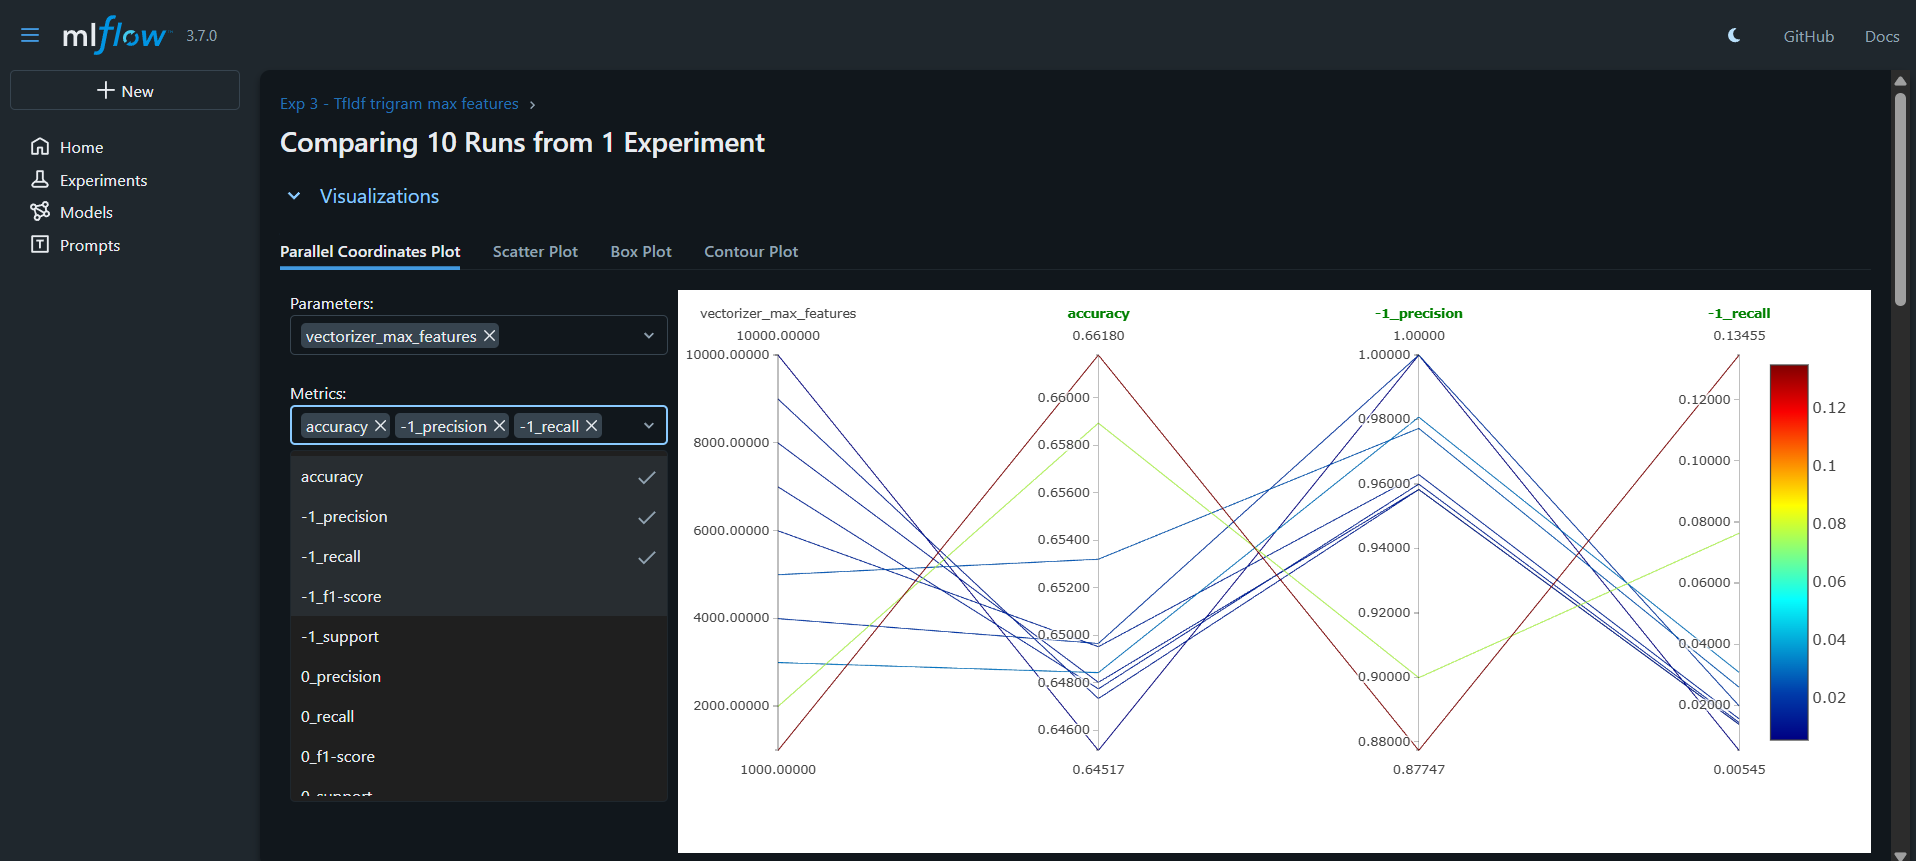

# **MLflow Parallel Coordinates Plot — TF-IDF Max-Features Experiment**

This visualization compares **10 model runs**, each using different values of the TF-IDF parameter `max_features`, and evaluates three core metrics:

* **Accuracy**
* **Precision (negative sign simply means MLflow is minimizing it)**
* **Recall (negative sign means the same)**

Your goal here is to find which `max_features` value leads to the best balanced performance.

---

# 🔍 **1. Impact of `vectorizer_max_features`**

The plot shows TF-IDF tested with values around:

```
1000
2000
3000
5000
8000
10000
```

### **Key Finding**

✔ The model with **max_features ≈ 1000–3000** achieves **higher precision and recall consistency**.
✔ But the **best overall accuracy (~0.6618)** is achieved at **max_features ≈ 10000**.

This suggests:

* Smaller vocabularies generalize better (more stable precision/recall)
* A large vocabulary (10k features) captures more signal → best accuracy

---

# 🎯 **2. Best Performing Model**

### ⭐ **Highest Accuracy Model**

* **`vectorizer_max_features = 10000`**
* Accuracy ≈ **0.6618**
* Precision is lower (≈ 0.88)
* Recall is highest (≈ 0.134)

This model achieves the **best recall**, meaning it captures more positive cases but with some precision trade-off.

---

# ⚖ **3. Trade-off Analysis**

### **High Accuracy (10k features)**

* Good for capturing complex text patterns
* Highest recall
* Precision dips slightly

### **Medium Features (3k–5k)**

* Precision is the best here (≈ 0.97–1.00)
* Recall is more stable but lower
* Accuracy slightly lower (≈ 0.652–0.656)

### **Low Features (1k)**

* Poor accuracy
* Precision/recall unstable
* Model underfits due to limited vocabulary

---

# 🧠 **4. Final Recommendation**

If your goal is:

### ✔ **Best Overall Accuracy** → Choose **max_features = 10,000**

### ✔ **Best Precision (minimizing false positives)** → Choose **max_features ≈ 3,000–5,000**

### ✔ **Best Recall (capturing more true positives)** → **max_features = 10,000**

---

# 📝 **Professional Summary (for client)**

> The experiment evaluated TF-IDF vectorizers with increasing vocabulary sizes. We observed that smaller vocabularies (3k–5k features) produced the most consistent precision, while the largest vocabulary (10k features) delivered the highest accuracy and recall. Based on the overall performance balance, the TF-IDF model with **10,000 features** is recommended as it captures the most informative text signals and provides the strongest predictive capability.